# Backtested Dynamic Confidence Intervals

This notebook demonstrates how to create an expanding confidence interval using conformal intervals and backtesting. It expands what is demonstrated in the [Confidence Intervals Notebook](https://scalecast-examples.readthedocs.io/en/latest/misc/cis/cis.html). Requires `scalecast>=0.18.1`.

We overwrite the static naive intervals produced by scalecast by default with dynamic expanding intervals obtained from backtesting.

In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.util import (
    metrics, 
    backtest_metrics,
    backtest_for_resid_matrix,
    get_backtest_resid_matrix,
    overwrite_forecast_intervals,
)
from scalecast.Pipeline import Pipeline, Transformer, Reverter
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
val_len = 24
fcst_len = 24

- Link to data: https://fred.stlouisfed.org/series/HOUSTNSA   

In [3]:
housing = pdr.get_data_fred('HOUSTNSA',start='1900-01-01',end='2021-06-01')
housing.head()

,HOUSTNSA
DATE,
1959-01-01,96.2
1959-02-01,99.0
1959-03-01,127.7
1959-04-01,150.8
1959-05-01,152.5


Hold out a test set since scalecast uses its native test set to determine interval widths, therefore overfitting the interval to the test set.

In [4]:
starts_sep = housing.iloc[-fcst_len:,0]
starts = housing.iloc[:-fcst_len,0]

In [5]:
f = Forecaster(
    y=starts,
    current_dates=starts.index,
    future_dates=fcst_len,
    test_length=val_len,
    validation_length=val_len,
    cis=True,
)

## Step 1: Build and fit_predict() Pipeline

In [6]:
transformer = Transformer(['DiffTransform'])
reverter = Reverter(['DiffRevert'],transformer)

In [7]:
def forecaster(f):
    f.add_ar_terms(100)
    f.add_seasonal_regressors('month')
    f.set_estimator('xgboost')
    f.manual_forecast()

In [8]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter)
    ]
)

In [9]:
f = pipeline.fit_predict(f)

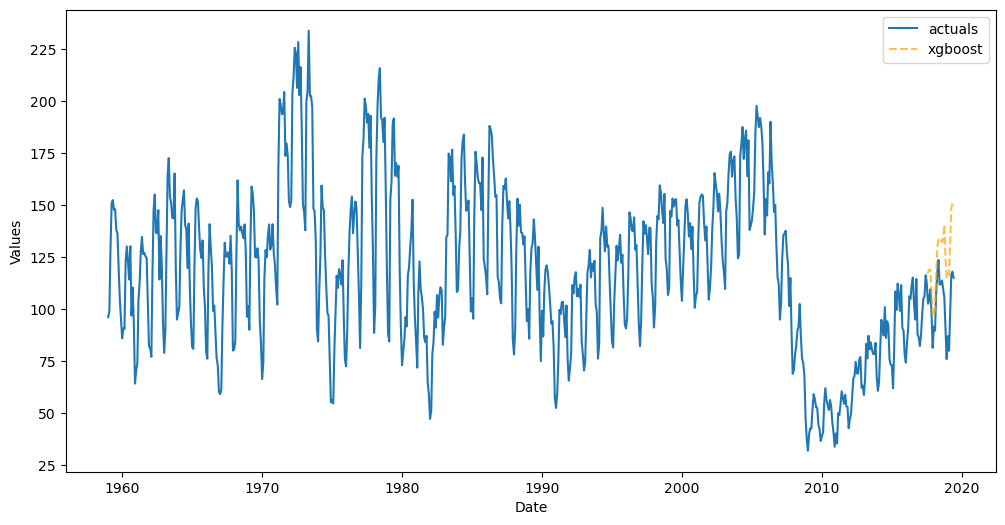

In [10]:
f.plot_test_set();

### Score the default Interval

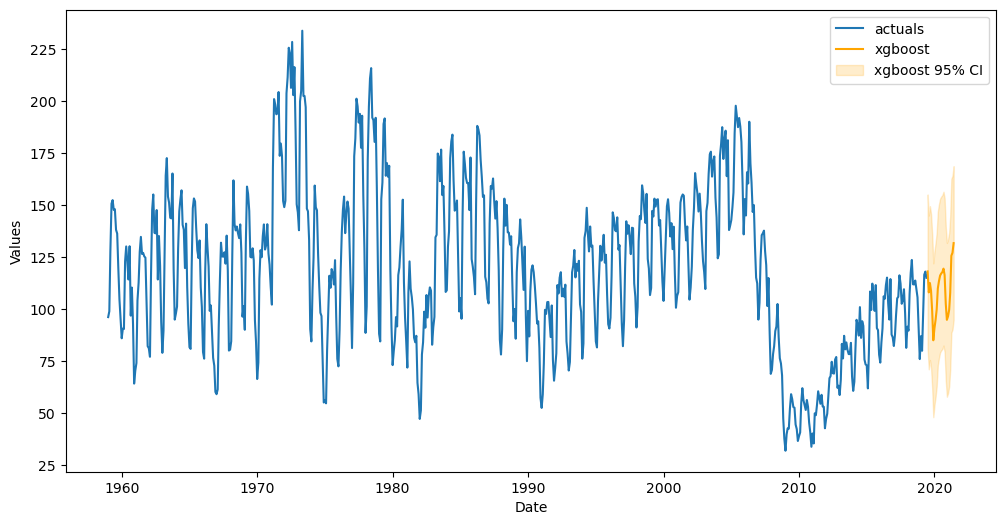

In [11]:
f.plot(ci=True);

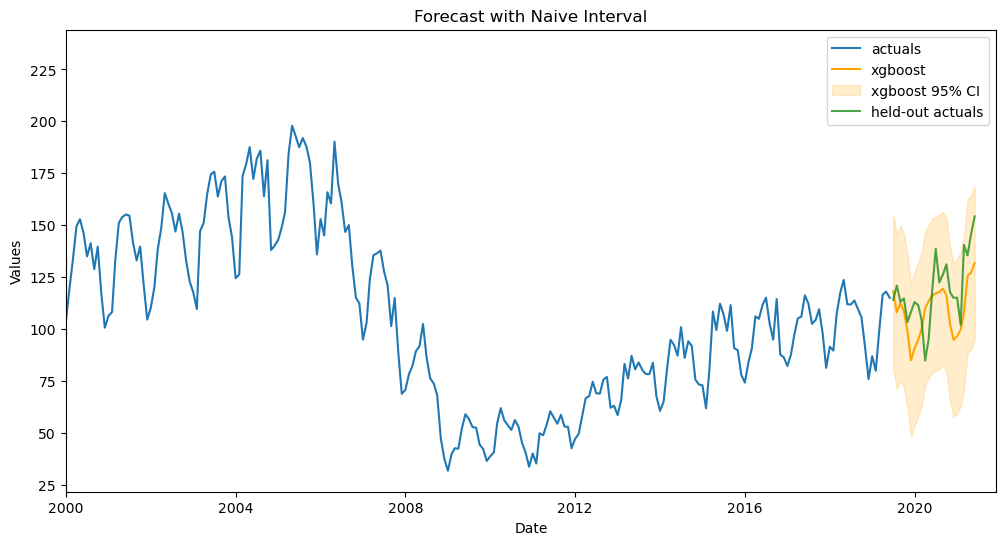

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models='top_1',order_by='TestSetRMSE',ax=ax)
sns.lineplot(
    y = 'HOUSTNSA',
    x = 'DATE',
    data = starts_sep.reset_index(),
    ax = ax,
    label = 'held-out actuals',
    color = 'green',
    alpha = 0.7,
)
plt.xlim(pd.Timestamp('2000-01-01'),pd.Timestamp('2021-12-01'))
plt.title('Forecast with Naive Interval')
plt.show()

In [13]:
print(
    'All confidence intervals for every step'
    ' are {:.2f} units away from the point predictions.'.format(
        f.history['xgboost']['UpperCI'][0] - f.history['xgboost']['Forecast'][0]
    )
)
print(
    'The interval contains {:.2%} of the actual values'.format(
        np.sum(
            [
                1 if a <= uf or a >= lf else 0 
                for a, uf, lf in zip(
                    starts_sep,
                    f.history['xgboost']['UpperCI'],
                    f.history['xgboost']['LowerCI']
                )
            ]
        ) / len(starts_sep)
    )
)

All confidence intervals for every step are 37.01 units away from the point predictions.
The interval contains 100.00% of the actual values


### Score default interval

In [14]:
metrics.msis(
    a = starts_sep,
    uf = f.history['xgboost']['UpperCI'],
    lf = f.history['xgboost']['LowerCI'],
    obs = f.y,
    m = 12,
)

4.026554265078705

## Step 2: Backtest Pipeline
- Iterations need to be at least 20 for 95% intervals.
- Length of each prediction in the backtest should match our desired forecast length.

In [15]:
%%time
backtest_results = backtest_for_resid_matrix(
    f,
    pipeline=pipeline,
    alpha = .05, # default
    jump_back = 1, # default
)

CPU times: user 58.6 s, sys: 20 s, total: 1min 18s
Wall time: 16 s


## Step 3: Build Residual Matrix
- Result is matrix shaped 20x24, each row a backtest iteration, each column a forecast step, each value a residual.

In [16]:
backtest_resid_matrix = get_backtest_resid_matrix(backtest_results)

### Residual Analytics

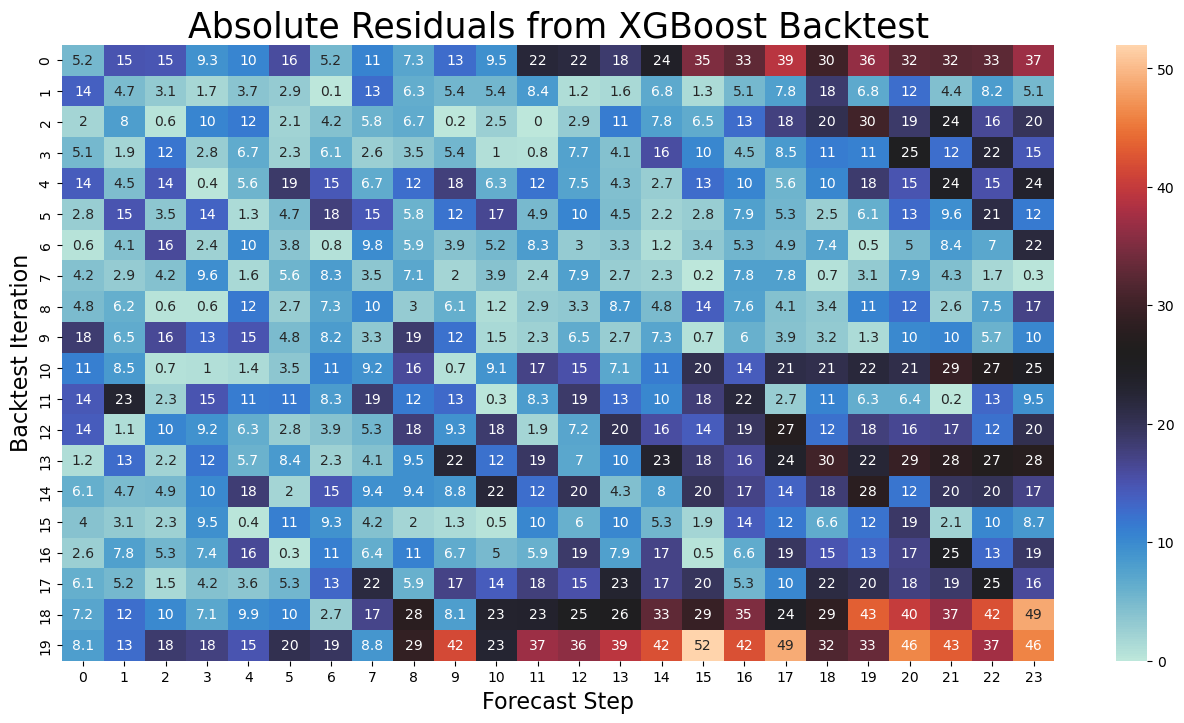

In [17]:
pd.options.display.max_columns = None
fig, ax = plt.subplots(figsize=(16,8))
mat = pd.DataFrame(np.abs(backtest_resid_matrix[0]['xgboost']))
sns.heatmap(
    mat.round(1),
    annot = True, 
    ax = ax, 
    cmap = sns.color_palette("icefire", as_cmap=True)
)
plt.ylabel('Backtest Iteration',size=16)
plt.xlabel('Forecast Step',size = 16)
plt.title('Absolute Residuals from XGBoost Backtest',size=25)
plt.show()

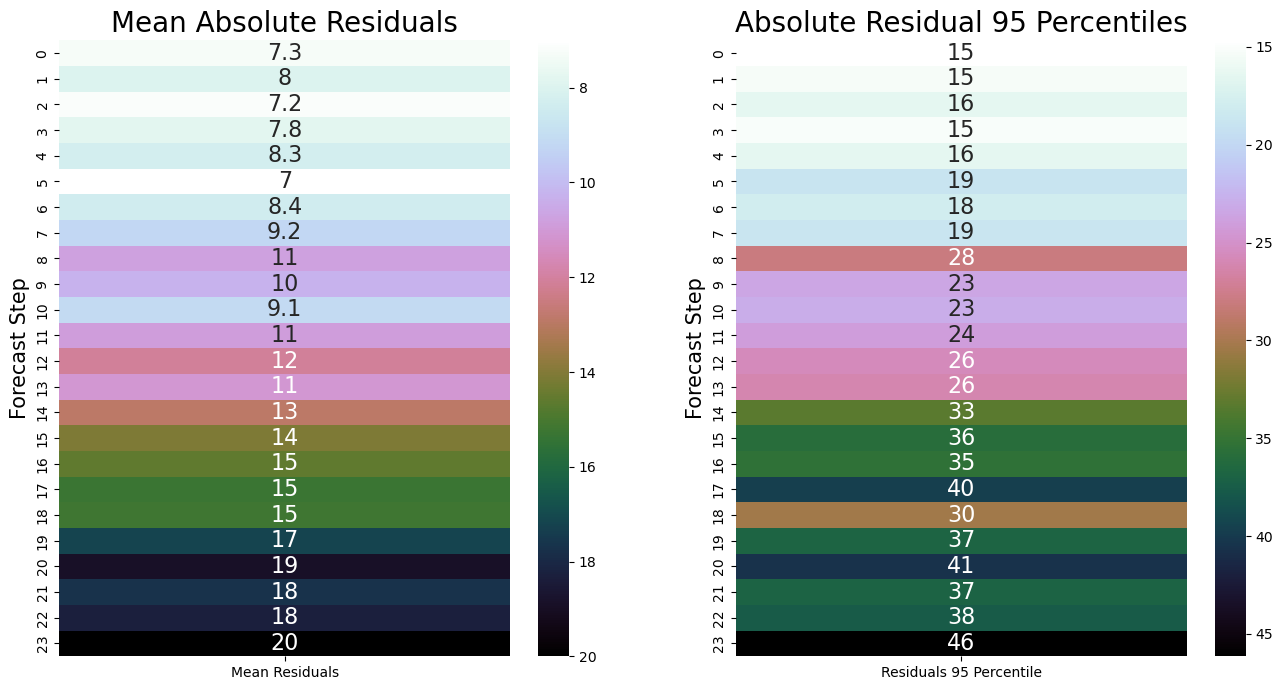

In [19]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.heatmap(
    pd.DataFrame({'Mean Residuals':mat.mean().round(1)}),
    annot = True, 
    cmap = 'cubehelix_r',
    ax = ax[0],
    annot_kws={"fontsize": 16},
)
cbar = ax[0].collections[0].colorbar
cbar.ax.invert_yaxis()
ax[0].set_title('Mean Absolute Residuals',size=20)
ax[0].set_ylabel('Forecast Step',size=15)
ax[0].set_xlabel('')
sns.heatmap(
    pd.DataFrame({'Residuals 95 Percentile':np.percentile(mat, q=95, axis = 0)}),
    annot = True,
    cmap = 'cubehelix_r',
    ax = ax[1],
    annot_kws={"fontsize": 16},
)
cbar = ax[1].collections[0].colorbar
cbar.ax.invert_yaxis()
ax[1].set_title('Absolute Residual 95 Percentiles',size=20)
ax[1].set_ylabel('Forecast Step',size=15)
ax[1].set_xlabel('')
plt.show()

Each step of the forecast will be plus/minus the 95 percentile of the absolute residuals (plot on right).

## Step 4: Overwrite Naive Interval with Dynamic Interval

In [20]:
overwrite_forecast_intervals(f,backtest_resid_matrix=backtest_resid_matrix)

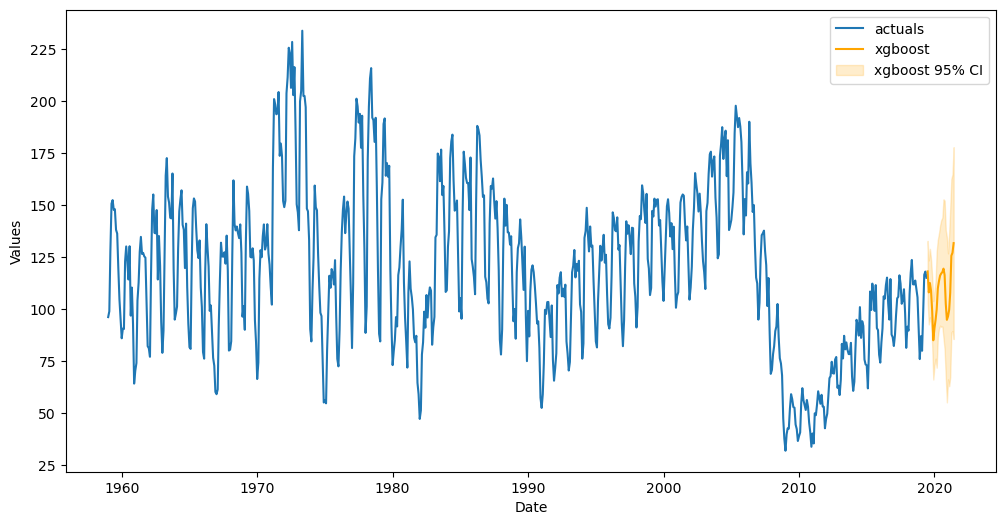

In [21]:
f.plot(ci=True);

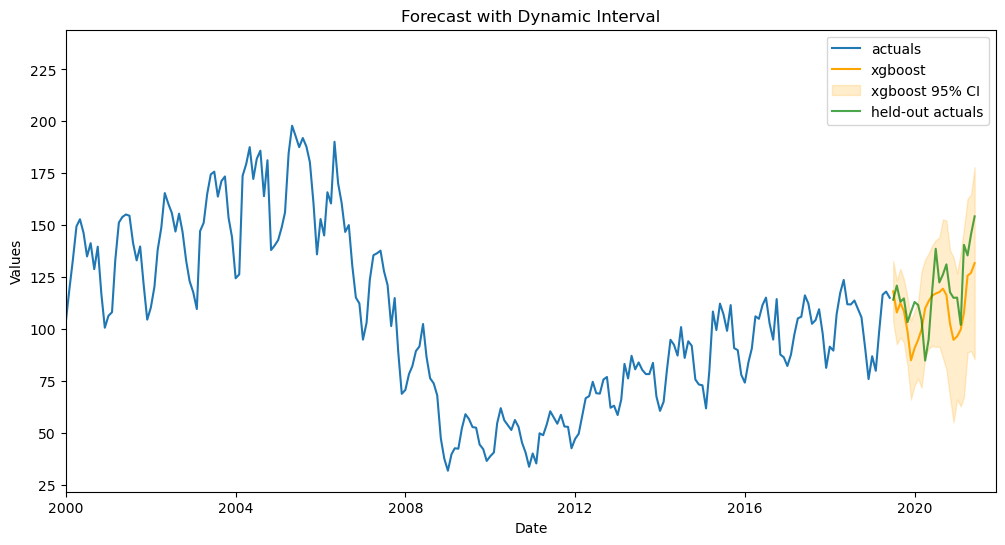

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models='top_1',order_by='TestSetRMSE',ax=ax)
sns.lineplot(
    y = 'HOUSTNSA',
    x = 'DATE',
    data = starts_sep.reset_index(),
    ax = ax,
    label = 'held-out actuals',
    color = 'green',
    alpha = 0.7,
)
plt.xlim(pd.Timestamp('2000-01-01'),pd.Timestamp('2021-12-01'))
plt.title('Forecast with Dynamic Interval')
plt.show()

## Score dynamic interval

In [23]:
metrics.msis(
    a = starts_sep,
    uf = f.history['xgboost']['UpperCI'],
    lf = f.history['xgboost']['LowerCI'],
    obs = f.y,
    m = 12,
)

3.919628517087574

It is a small improvement, but still an improvement!

In [24]:
print(
    'The intervals are on average {:.2f} units away from the point predictions.'.format(
        np.mean(np.percentile(mat, q=95, axis = 0))
    )
    
)
print(
    'The interval contains {:.2%} of the actual values'.format(
        np.sum(
            [
                1 if a <= uf or a >= lf else 0 
                for a, uf, lf in zip(
                    starts_sep,
                    f.history['xgboost']['UpperCI'],
                    f.history['xgboost']['LowerCI']
                )
            ]
        ) / len(starts_sep)
    )
)

The intervals are on average 27.36 units away from the point predictions.
The interval contains 100.00% of the actual values


## Other Backtest Uses
- We can also use the backtest results to report average error metrics over 20 out-of-sample sets.

In [25]:
backtest_metrics(backtest_results,mets=['rmse','mae','bias'])[['Average']]

Average
Model   Metric            
xgboost rmse     14.083597
        mae      12.144780
        bias    239.430706

In [26]:
# actual rmse on out-of-sample data
metrics.rmse(starts_sep,f.history['xgboost']['Forecast'])

16.208569138706174